In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# kNN

In [56]:
# Initializing a DataFrame to log accuracy for each run
log_accuracy = pd.DataFrame(columns=['Run', 'ModelAccuracy']).set_index('Run')

# Executing 100 runs to assess model's performance
for run in range(0, 100):  
    # Reloading the dataset for every run
    nhanes_data = pd.read_csv("NHANES_data_train.csv")
    
    # Splitting data into train and test subsets randomly
    train_set, test_set = train_test_split(nhanes_data, test_size=0.2, random_state=run)
    
    # Calculating the number of MI and no MI cases in both subsets
    mi_train_count = (train_set["MI"] == 1).sum()
    no_mi_train_count = (train_set["MI"] == 2).sum()
    mi_test_count = (test_set["MI"] == 1).sum()
    no_mi_test_count = (test_set["MI"] == 2).sum()
    
    # Gathering MI and no MI cases separately from train and test sets
    mi_train = train_set[train_set["MI"] == 1]
    no_mi_train = train_set[train_set["MI"] == 2].sample(frac=mi_train_count/no_mi_train_count)
    mi_test = test_set[test_set["MI"] == 1]
    no_mi_test = test_set[test_set["MI"] == 2]
    
    # Applying KNN imputation to fill in missing values
    knn_imputer = KNNImputer(n_neighbors=21)
    mi_train_imputed = pd.DataFrame(knn_imputer.fit_transform(mi_train), columns=mi_train.columns)
    no_mi_train_imputed = pd.DataFrame(knn_imputer.fit_transform(no_mi_train), columns=no_mi_train.columns)
    mi_test_imputed = pd.DataFrame(knn_imputer.fit_transform(mi_test), columns=mi_test.columns)
    no_mi_test_imputed = pd.DataFrame(knn_imputer.fit_transform(no_mi_test), columns=no_mi_test.columns)
    
    # Merging and shuffling imputed datasets for modeling
    final_train_set = pd.concat([mi_train_imputed, no_mi_train_imputed]).sample(frac=1)
    final_test_set = pd.concat([mi_test_imputed, no_mi_test_imputed]).sample(frac=1)
    
    # Configuring KNN classifier and standardizing features
    knn_model = KNeighborsClassifier(n_neighbors=25, metric='manhattan')
    feature_scaler = StandardScaler()
    
    # Adjusting feature importance through weighting
    importance_weights = np.array([0.5, 0.7, 1.0, 0.5, 0.3, 1.5, 1.0, 1.5, 1.3, 2.0, 1.3, 1.0, 2.5, 1.0, 1.0, 1.3, 1.5, 1.0])
    
    # Preparing data for model
    train_features = feature_scaler.fit_transform(final_train_set.drop(['ParticipantID', 'MI'], axis=1)) * importance_weights
    train_labels = final_train_set["MI"]
    test_features = feature_scaler.transform(final_test_set.drop(['ParticipantID', 'MI'], axis=1)) * importance_weights
    test_labels = final_test_set["MI"]
    
    # Fitting the model and predicting on test data
    knn_model.fit(train_features, train_labels)
    predictions = knn_model.predict(test_features)
    
    # Recording the model's accuracy for the current run
    current_accuracy = accuracy_score(test_labels, predictions)
    log_accuracy.loc[run, 'ModelAccuracy'] = current_accuracy


avg accuracy: 0.7632843137254904

median accuracy: 0.7640931372549019

highest accuracy: 0.8284313725490197

Lowest accuracy: 0.6997549019607843

accuracy range: 12.86764705882354%



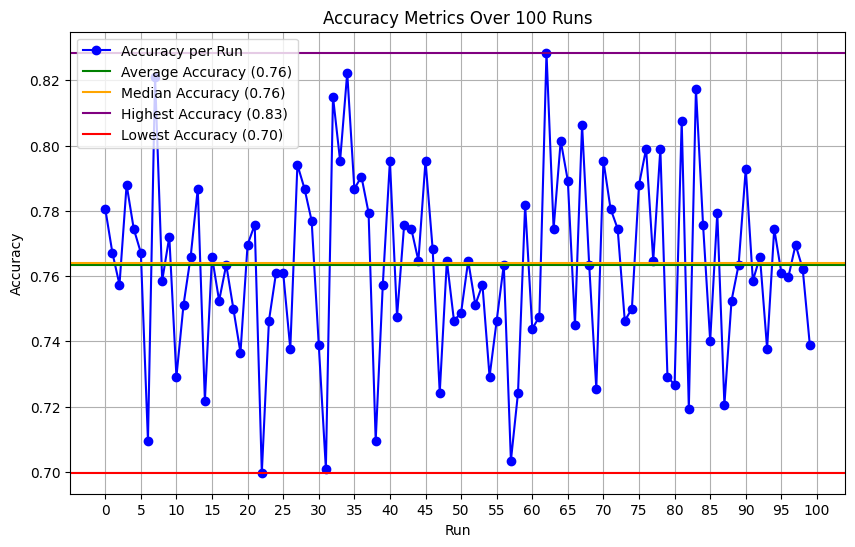

In [57]:
##------------------------------------------------------------ break in data analysis -----------------------------------------------------------------

print("avg accuracy: " + str(avgList['avg'].mean()) + '\n')
print("median accuracy: " + str(avgList['avg'].median()) + '\n')
print("highest accuracy: " + str(avgList['avg'].max()) + '\n')
print("Lowest accuracy: " + str(avgList['avg'].min()) + '\n')
print("accuracy range: " + str((avgList['avg'].max() - avgList['avg'].min()) * 100) + '%\n')


# Plotting the accuracy values
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(avgList.index, avgList['avg'], label='Accuracy per Run', marker='o', linestyle='-', color='blue')

# Calculating the statistics
average_accuracy = avgList['avg'].mean()
median_accuracy = avgList['avg'].median()
highest_accuracy = avgList['avg'].max()
lowest_accuracy = avgList['avg'].min()

# Adding lines for average, median, highest, and lowest
plt.axhline(y=average_accuracy, color='green', linestyle='-', label=f'Average Accuracy ({average_accuracy:.2f})')
plt.axhline(y=median_accuracy, color='orange', linestyle='-', label=f'Median Accuracy ({median_accuracy:.2f})')
plt.axhline(y=highest_accuracy, color='purple', linestyle='-', label=f'Highest Accuracy ({highest_accuracy:.2f})')
plt.axhline(y=lowest_accuracy, color='red', linestyle='-', label=f'Lowest Accuracy ({lowest_accuracy:.2f})')

plt.legend()
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy Metrics Over 100 Runs')
plt.xticks(range(0, 101, 5))  # Adjust x-axis ticks if necessary
plt.grid(True)  # Adds a grid for better readability

plt.show()

# Saving kNN to CSV

In [54]:
adjusted_predictions = (predictions - 1).astype(int)
# Ensure the ParticipantID is treated as an integer and predictions are binary
results_df = pd.DataFrame({
    'ParticipantID': fTestSample['ParticipantID'].astype(int).values,  # Convert to int to remove trailing .0
    'Predicted_MI': adjusted_predictions  # Assuming these are already binary; if not, adjust as shown below
})

# If your model outputs probabilities, convert to binary predictions with a threshold, e.g., 0.5
# Uncomment the following line if necessary
# results_df['Predicted_MI'] = (results_df['Predicted_MI'] >= 0.5).astype(int)

# Save the predictions to a CSV file without index
results_df.to_csv("kNN_predictions.csv", index=False)

# Display a message to indicate the file has been saved
print("Predictions have been saved to kNN_predictions.csv")


Predictions have been saved to kNN_predictions.csv


# Logistic Regression

In [55]:
# Load data
data = pd.read_csv("NHANES_data_train.csv")  # Replace with the path to your dataset

# Replace 'NA' with np.nan to properly identify missing values
data.replace('NA', np.nan, inplace=True)

# Define categorical and numerical features
categorical_features = ['Sex', 'Race', 'Edu', 'Diabetes', 'CurrentSmoker', 'isActive', 'isInsured']
numerical_features = ['Income', 'Age', 'Diastolic', 'Systolic', 'Pulse', 'BMI', 'HDL', 'Trig', 'LDL', 'TCHOL', 'kidneys_eGFR']

# Define the preprocessing for numeric features: imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define the preprocessing for categorical features: imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))])

# Separate features and target variable, preserving ParticipantID
X = data.drop(['MI'], axis=1)
y = data['MI'].apply(lambda x: 0 if x == 2 else 1)  # Convert MI from 2/1 to 0/1

# Store ParticipantID separately
participant_ids = X['ParticipantID']

# Now drop 'ParticipantID' from X as it's not a feature for model training
X = X.drop(['ParticipantID'], axis=1)

# Split the dataset, preserving ParticipantID for the test set
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, participant_ids, test_size=0.2, random_state=42)

# After model predictions
output_df = pd.DataFrame({
    'ParticipantID': ids_test,  # Use preserved ParticipantIDs for the test set
    'Pred_Probability': pred_probs
})

output_df.to_csv("LR_model_predictions.csv", index=False)
print("Model predictions saved to LR_model_predictions.csv.")


Model predictions saved to LR_model_predictions.csv.


# Random Plotting

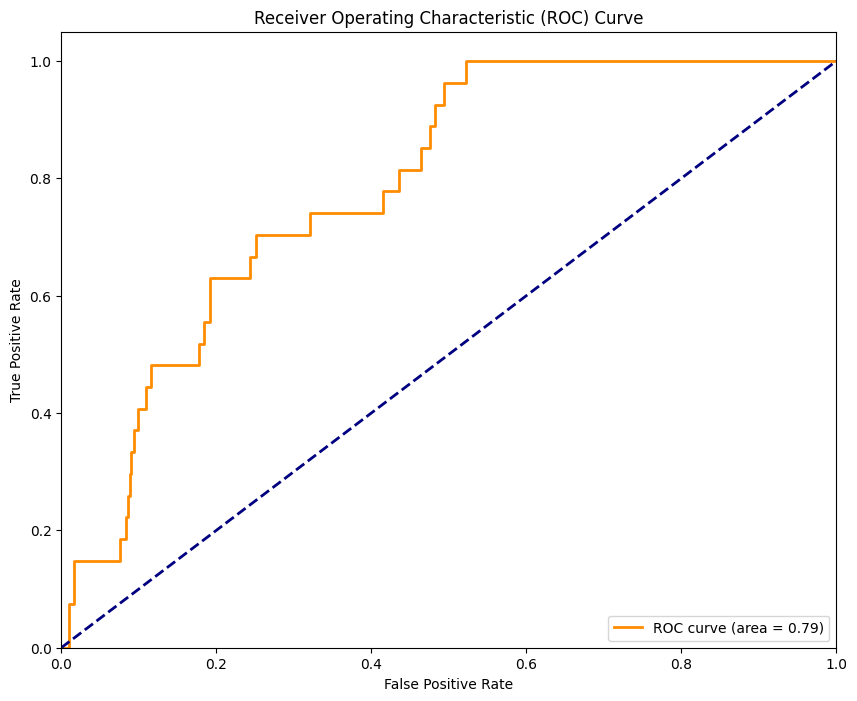

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a trained logistic regression model and test set ready
# pred_probs = model_pipeline.predict_proba(X_test)[:, 1] as from previous context

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


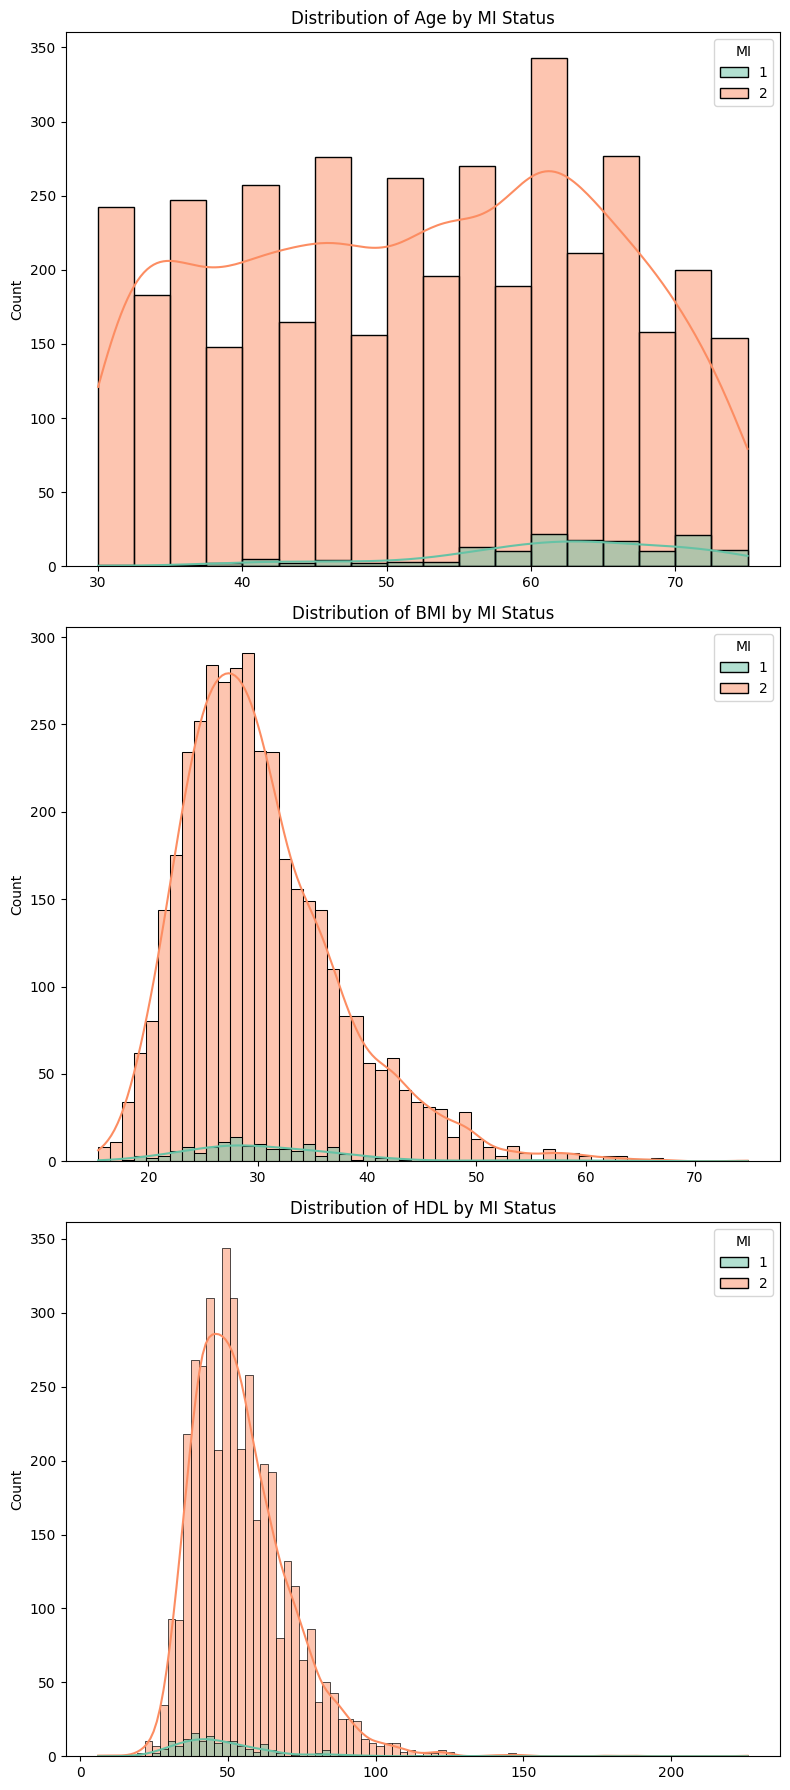

In [60]:
import seaborn as sns

# Assuming 'data' is your DataFrame and it includes the target variable 'MI'
features = ['Age', 'BMI', 'HDL']  # Example features, adjust based on your dataset

fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 6*len(features)))
for i, feature in enumerate(features):
    sns.histplot(data=data, x=feature, hue="MI", kde=True, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Distribution of {feature} by MI Status')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
plt.tight_layout()

/tmp/ipykernel_8833/100840187.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MI', y=feature, data=data, palette="Set3")
/tmp/ipykernel_8833/100840187.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='MI', y='Age', data=data, palette="Set3", split=True)


Text(0.5, 1.0, 'Age Distribution by MI Status')

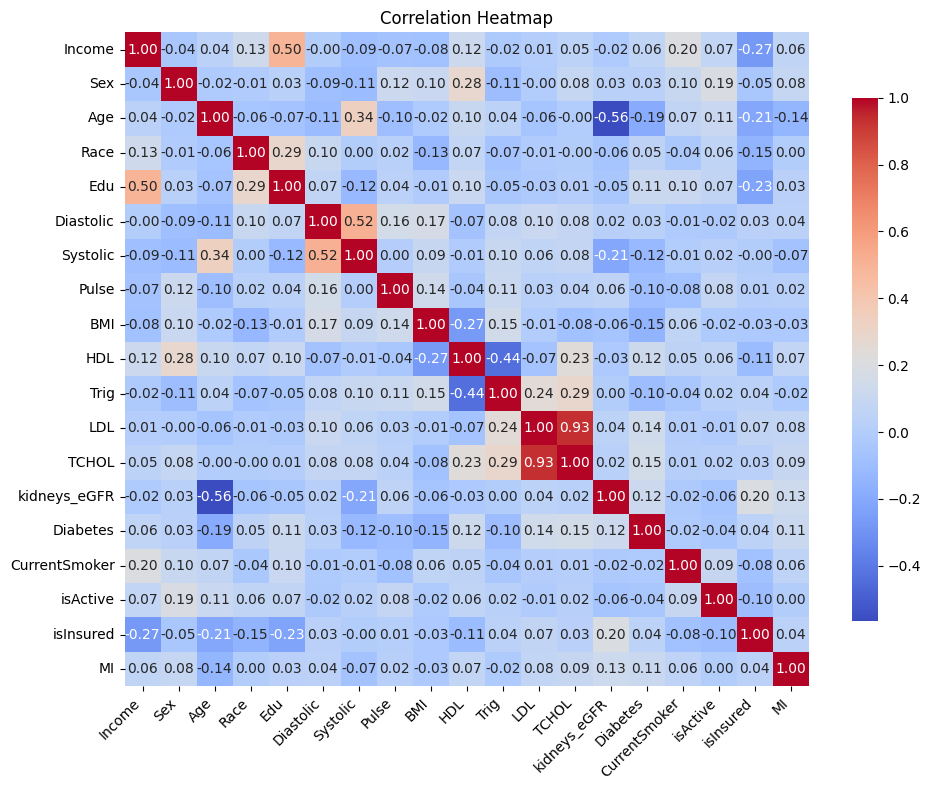

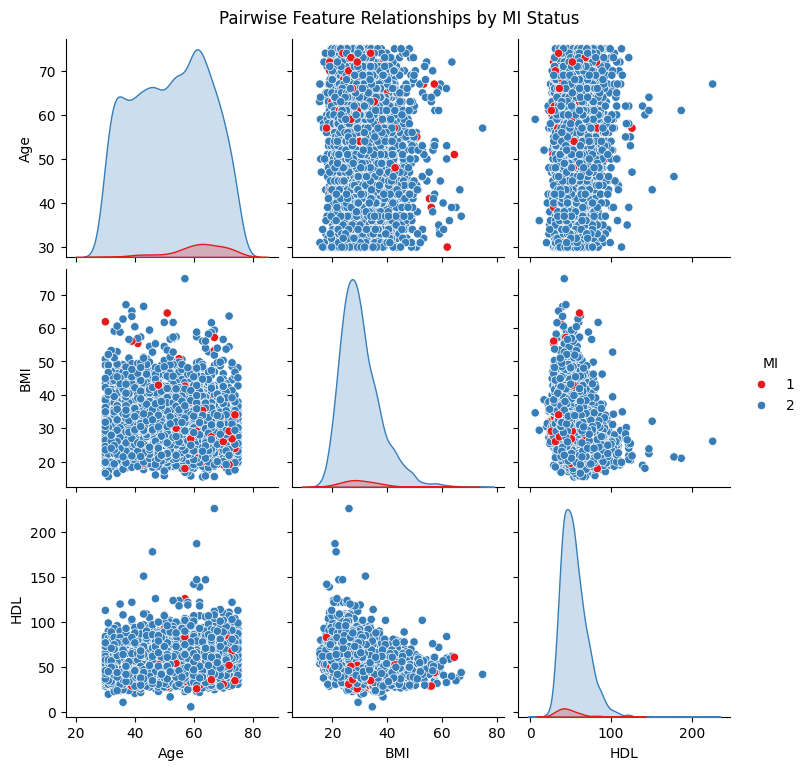

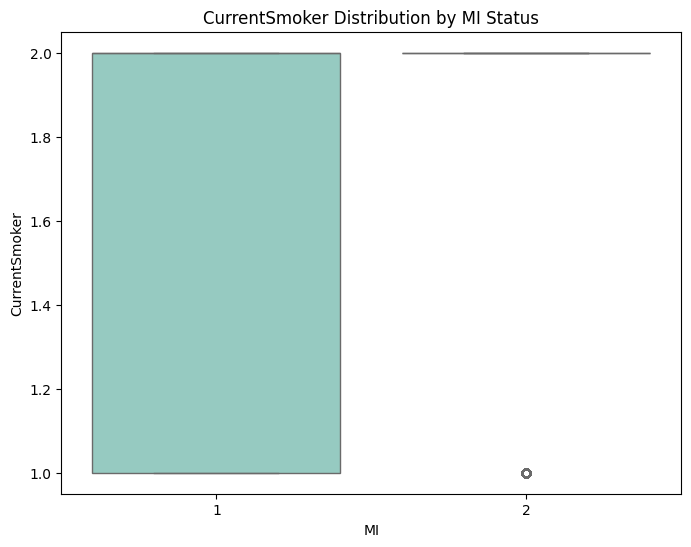

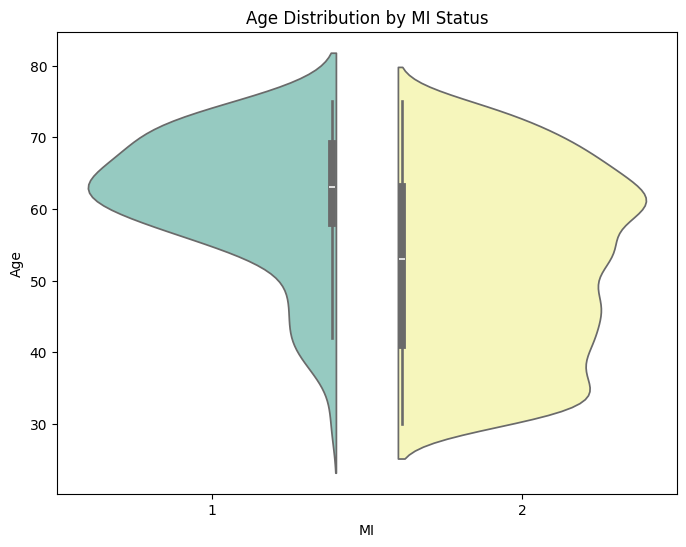

In [62]:
# Calculate correlations
corr = data.drop(['ParticipantID'], axis=1).corr()  # Drop 'ParticipantID' to focus on actual features and target

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Select a subset of features to avoid overcrowding, adjust as needed
subset_data = data[['MI', 'Age', 'BMI', 'HDL']]  # Example features

# Plot
sns.pairplot(subset_data, hue='MI', palette='Set1', diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships by MI Status', y=1.02)

#BoxPlot
feature = 'CurrentSmoker'  # Example feature
plt.figure(figsize=(8, 6))
sns.boxplot(x='MI', y=feature, data=data, palette="Set3")
plt.title(f'{feature} Distribution by MI Status')

#ViolinPlot
plt.figure(figsize=(8, 6))
sns.violinplot(x='MI', y='Age', data=data, palette="Set3", split=True)
plt.title('Age Distribution by MI Status')

